In [1]:
# Import libraries 
from sklearn.datasets import load_iris
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = (40,10)
%matplotlib inline

In [2]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
#Swap classes 0 and 2 because I am too lazy to draw more than one decision boundary
y[y == 0] = 3
y[y == 2] = 0
y[y == 3] = 2

# Often the data is stored in some order, so to ensure we have a fairly balanced train and validation set, shuffle the data first

rand_idx = np.random.permutation(len(y))
X = X[rand_idx, ...]
y = y[rand_idx]

X_tr = X[:105, ...]
y_tr = y[:105]
X_te = X[105:, ...]
y_te = y[105:]

print(f"There are {len(y_tr)} training data samples, and {len(y_te)} testing data samples")

There are 105 training data samples, and 45 testing data samples


First, let's load a simple data set about the Iris flower (this dataset is also available in Matlab).  For visualization purposes, we'll only use the first three features.  The dataset has three classes (0,1,2).  We are only going to perform training on the first 105 data samples and validate on the remaining 45 (This is called a 70/30 split).

For multiclass class logistic regression, we use cross-entropy loss, defined as:

\begin{equation}L = -\sum_j y_j \log p_j,\end{equation}

So, the derivative of the cross-entropy with softmax w.r.t w:

\begin{equation}
\frac{\partial L}{\partial w_i} = (p_i - y_i) x_i
\end{equation}

Explanation how the derivation is found: https://deepnotes.io/softmax-crossentropy

In [3]:
def softmax(z):
    probs = np.exp(z - z.max(axis=1, keepdims=True)) #This is to stabilize it numerically
    probs_norm = probs / probs.sum(axis=1, keepdims=True)
    return probs_norm


def compute_loss(p, y):
    #Use one-hot encoding to do some fancy indexing so we're taking the p=softmax(Wx+b) column that 
    #corresponds to the correct class y =[0,1,2]
    return np.mean(-np.log(p[range(len(p)), y]))

def l2_loss(W):
    return np.sum(W**2)

def compute_gradient(X, p, y_onehot):
    #Need to reshape the matrix so the matrix multiplication works properly
    dW = (p - y_onehot).reshape((X.shape[0], 1, 3)) * X.reshape((X.shape[0], 2, 1))
    dW = np.mean(dW, axis=0)
    db = (p - y_onehot).mean(axis=0)
    return dW, db
    

#This time we don't use a threshold, but take the class with the highest probability        
def predict(pred):
    return np.argmax(pred, axis=1)

def predict_prob(X, W, b):
    p = softmax(np.matmul(X, W) + b)
    return p    


def plot(X, y, W, b):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
    plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='g', label='2')
    plt.legend();
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    probs = predict_prob(grid, W, b)   
    probs = np.argmax(probs, axis=1).reshape(xx1.shape)
    plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

Define the parameters we are going to train.  There are two: W (weights) and b (bias).  The weights is a 2x3 matrix because we have 2 feature inputs and 3 output classes. The bias is a 1x3 because we have 3 output class.

In [4]:
print("Initializing...")
num_class = 3 #
# Initialize W to very small random values. e
W = 2e-3 * (np.random.rand(np.prod(X_tr.shape[1:]), num_class) - 0.5)

# Initialize b to zeros
b = np.zeros(num_class)

print(f"X = {X.shape}")
print(f"W = {W.shape}")
print(f"b = {b.shape}")

Initializing...
X = (150, 2)
W = (2, 3)
b = (3,)


We are going to train for 50,000 loops.  This is called an epoch.  For each epoch we are going to going to calculate the gradients and perform gradient descent optimization.  If you modify the data to divide the training data in to chucks or "batches" of shuffled or randomized training data (i.e. you re-shuffle the data every epoch) then this is stochastic gradient descent.  The training then becomes non-deterministic.

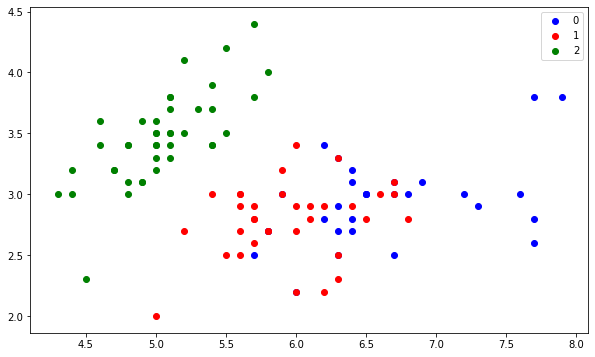

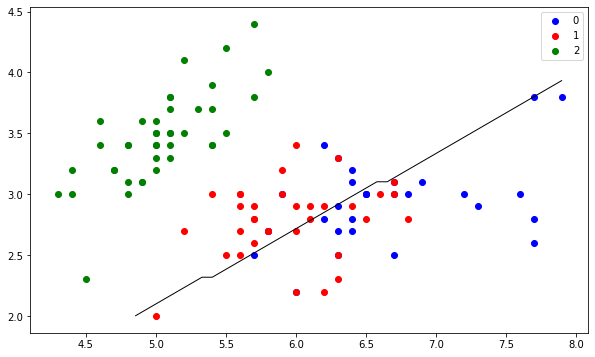

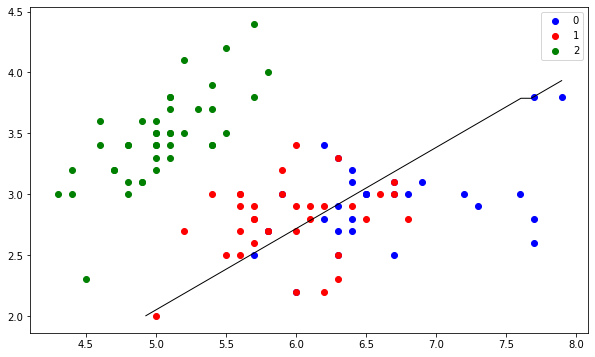

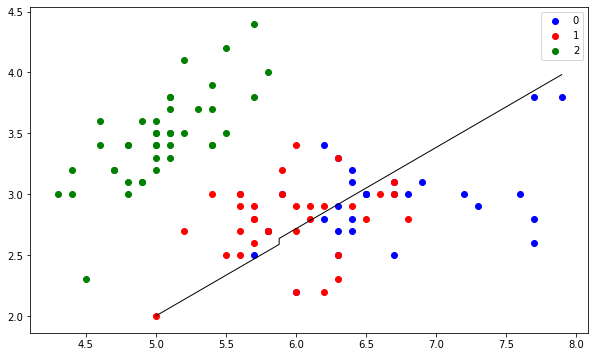

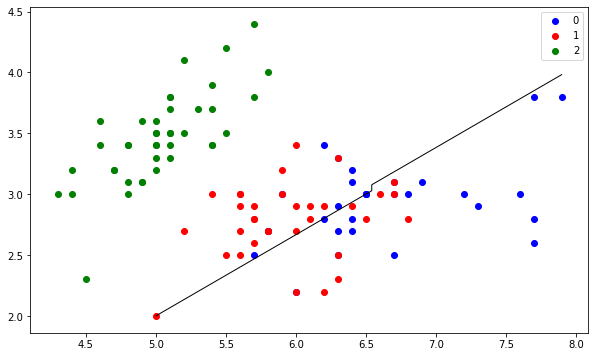

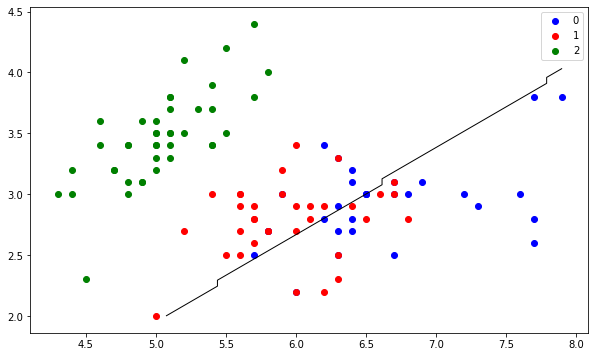

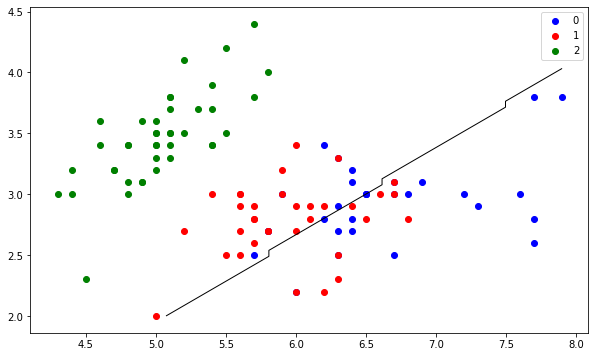

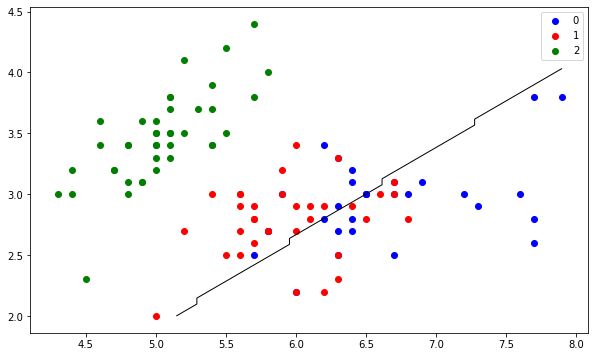

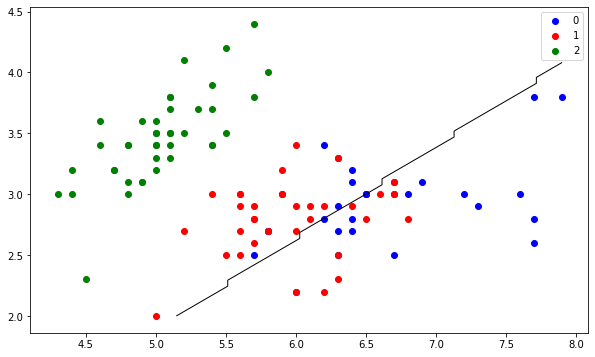

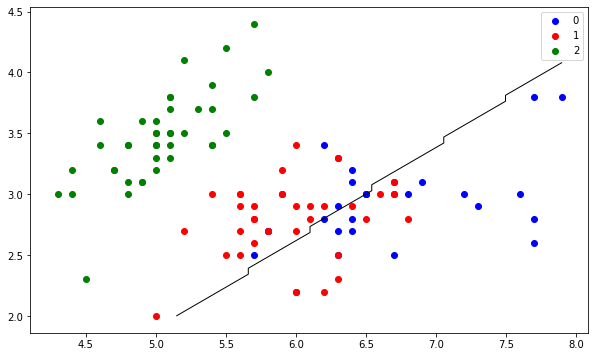

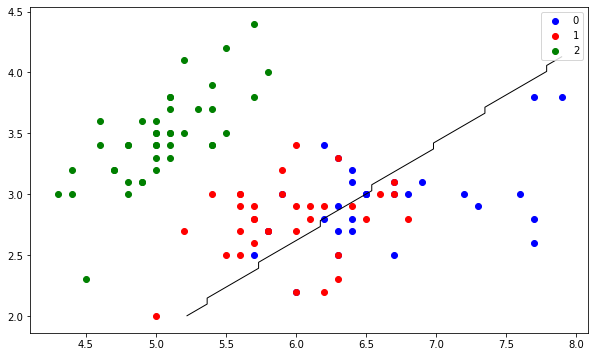

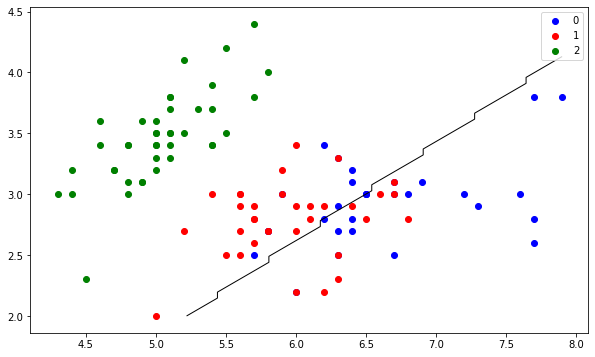

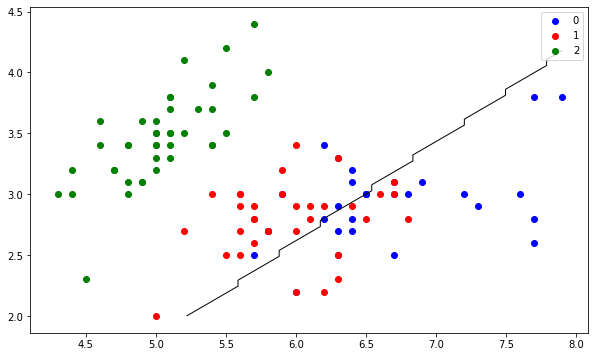

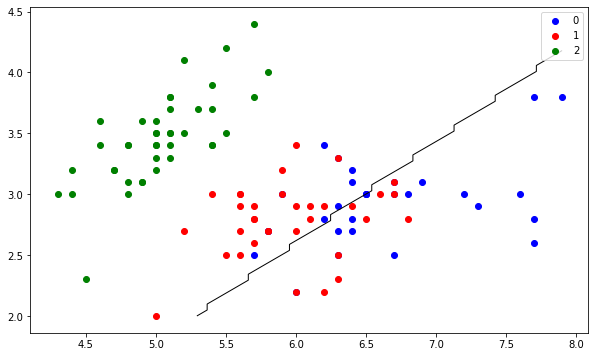

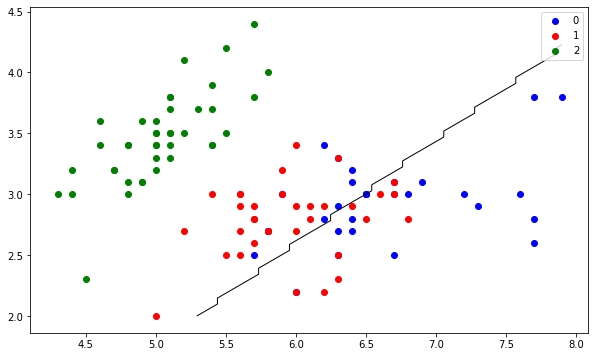

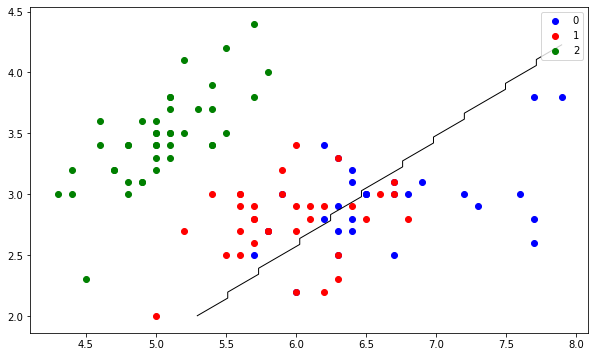

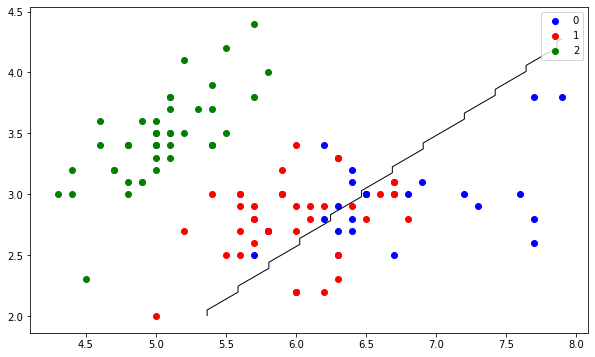

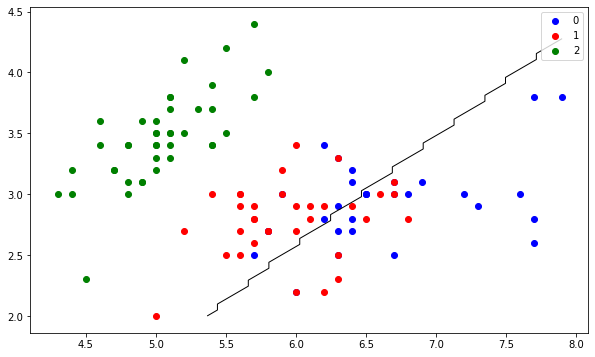

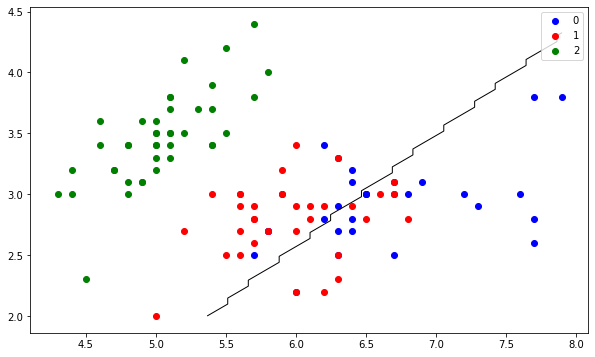

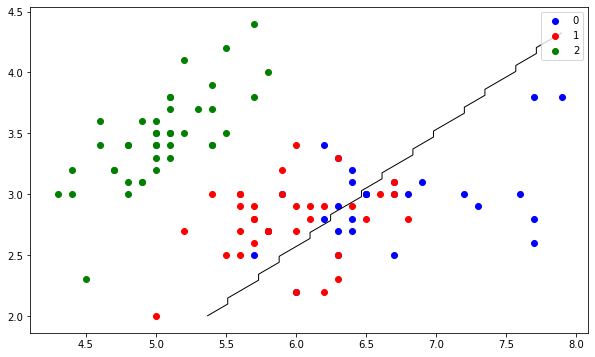

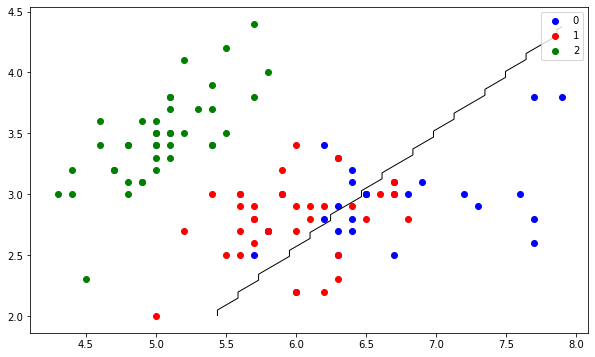

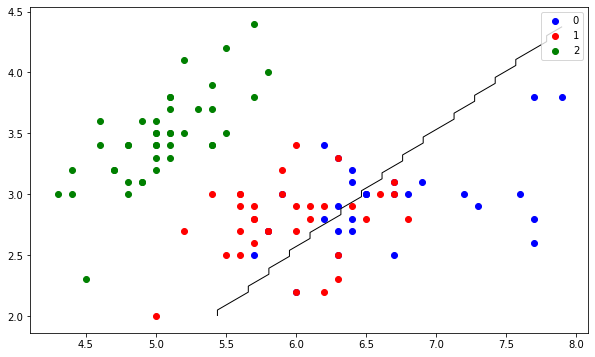

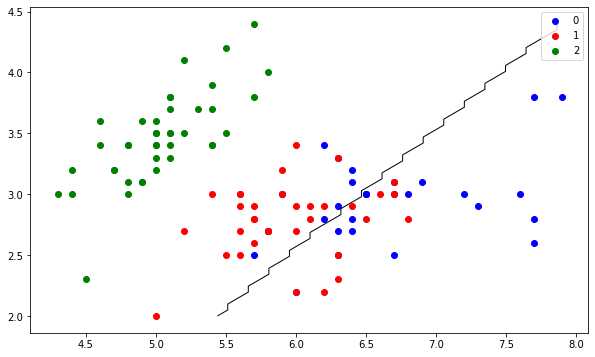

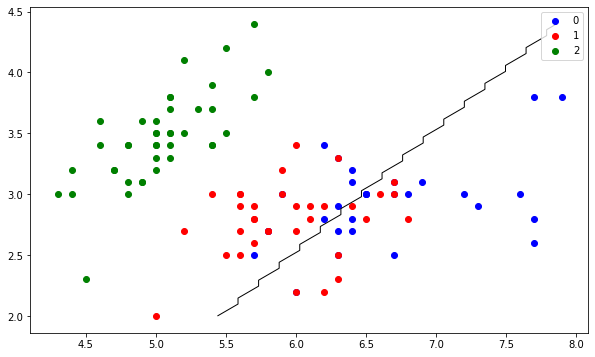

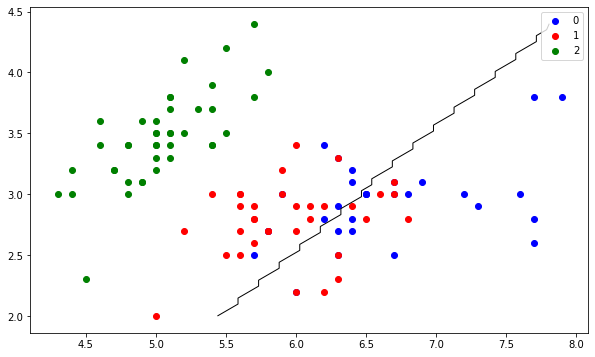

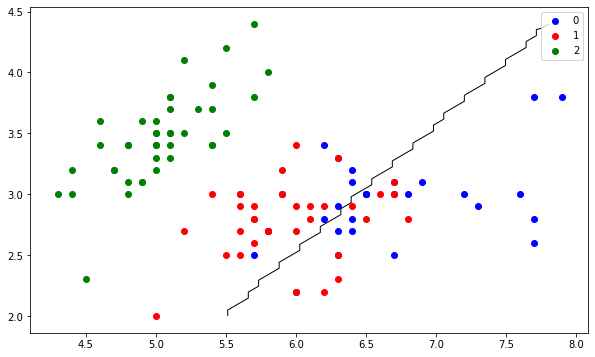

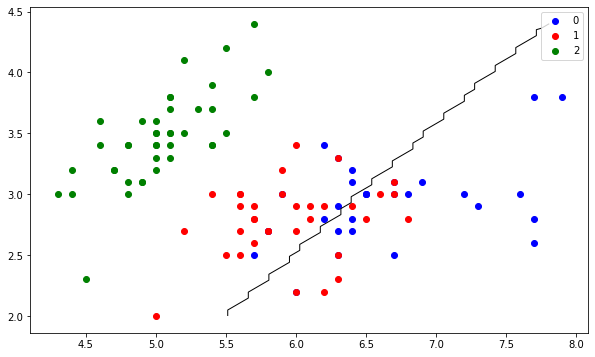

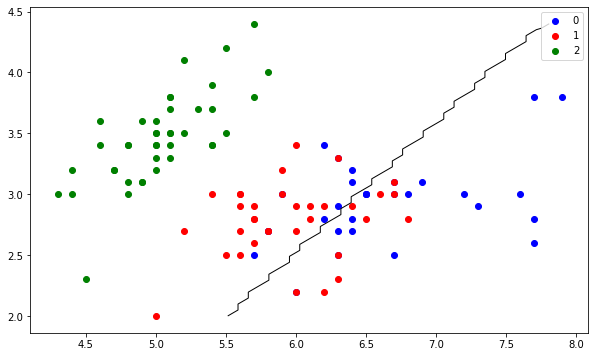

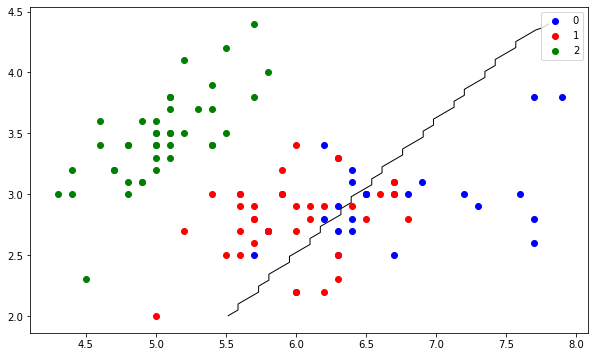

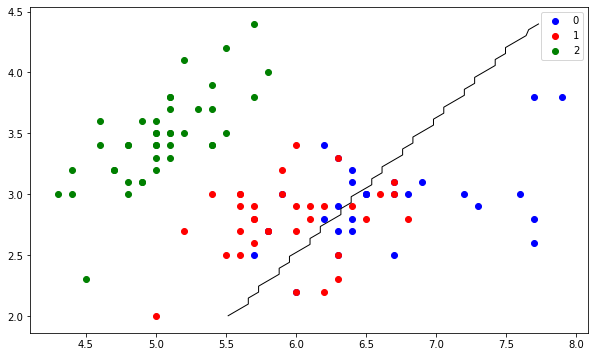

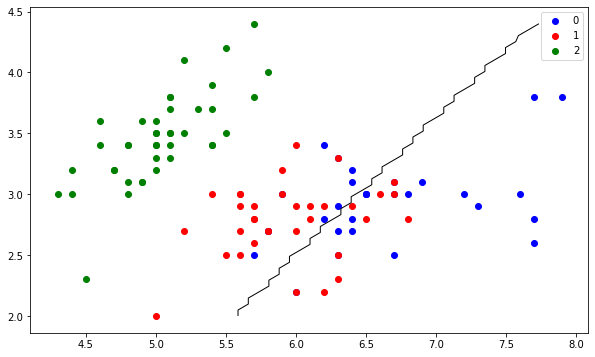

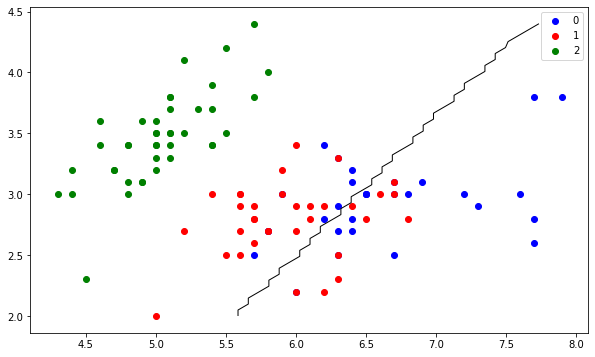

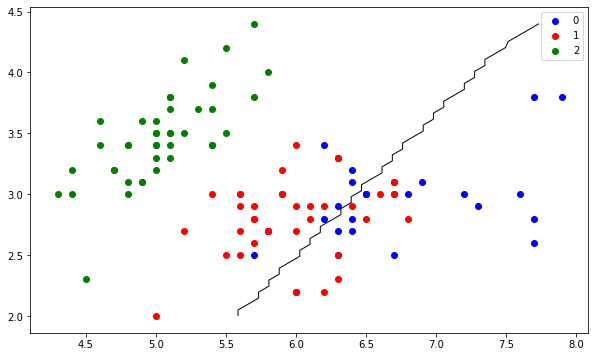

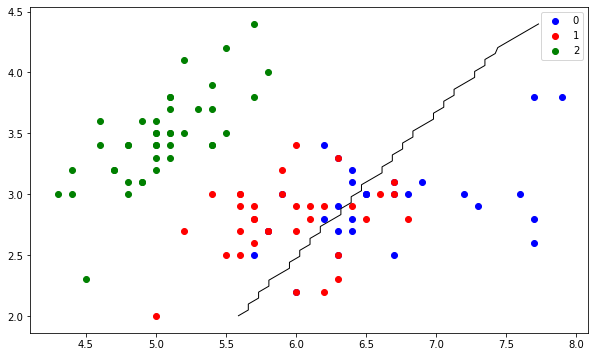

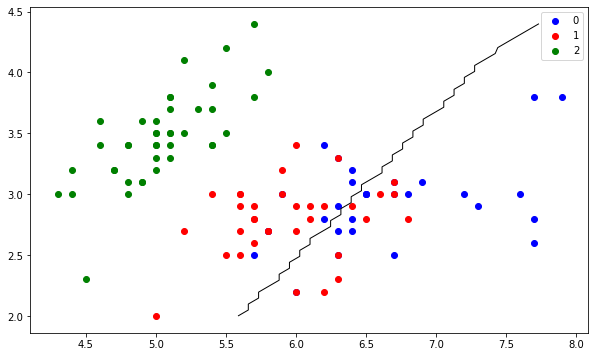

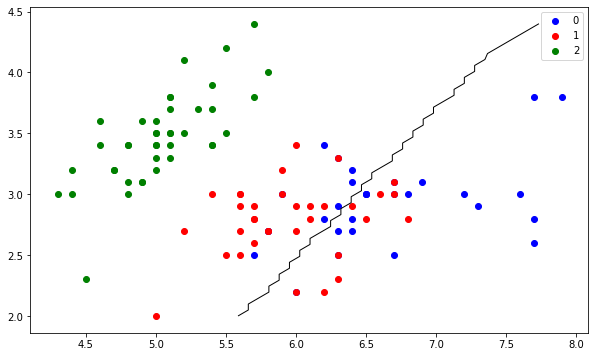

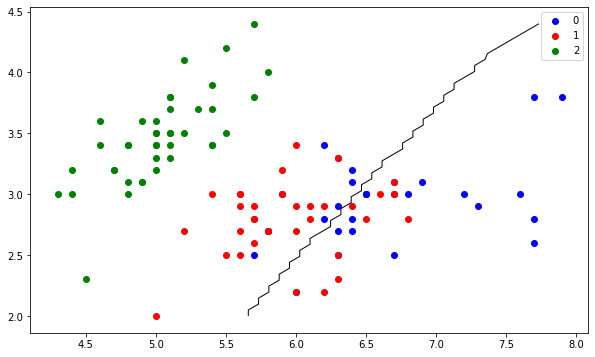

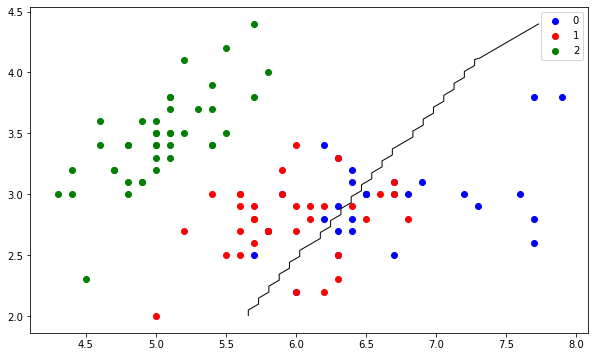

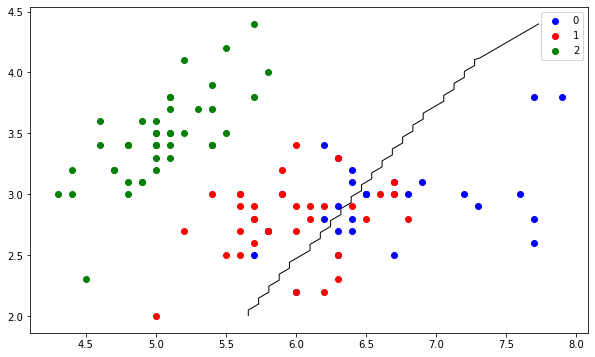

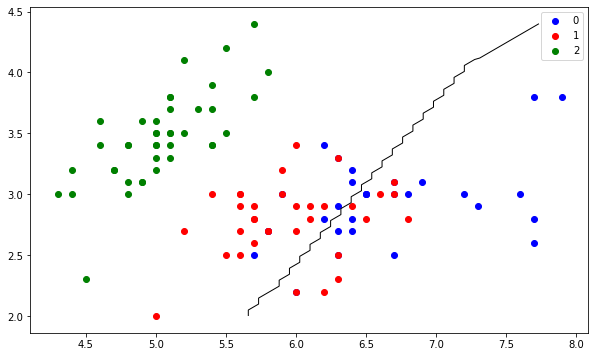

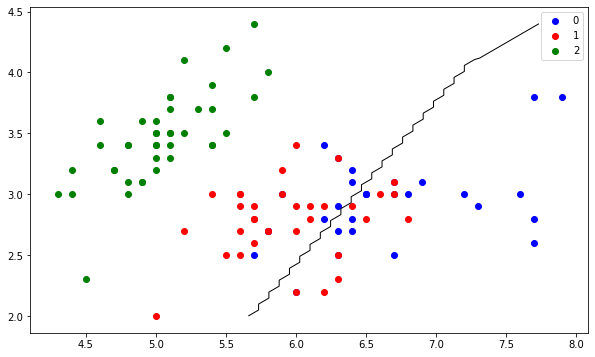

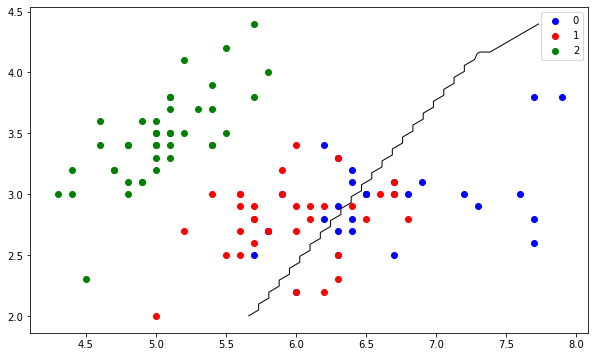

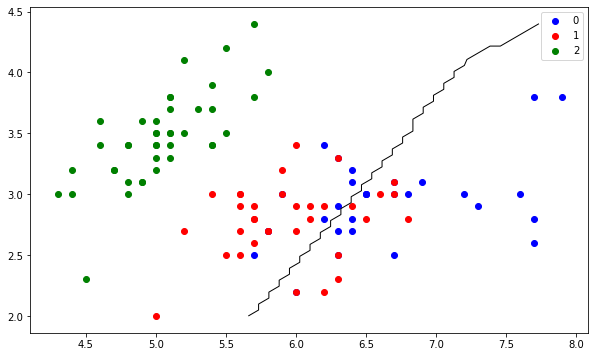

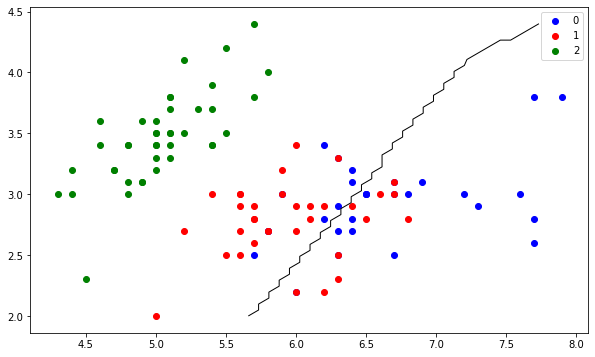

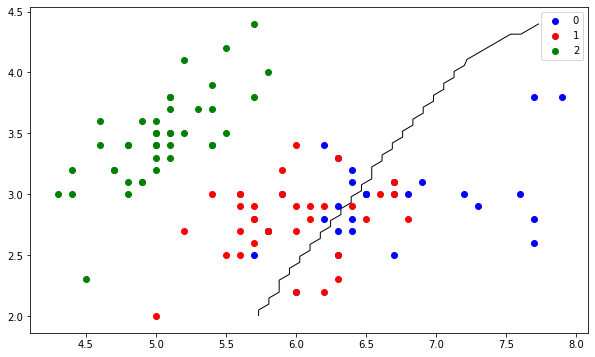

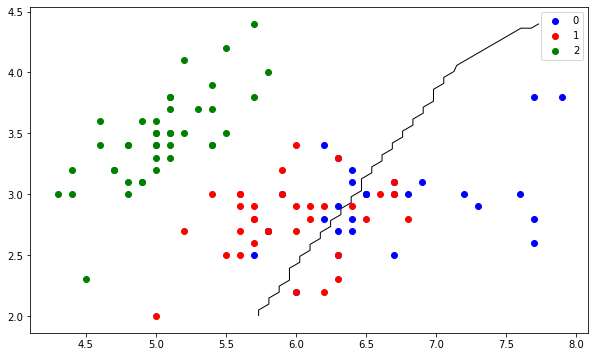

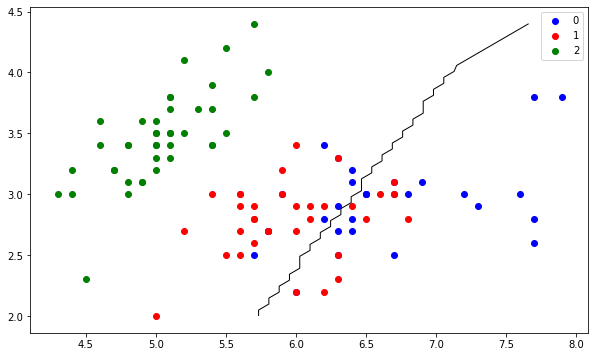

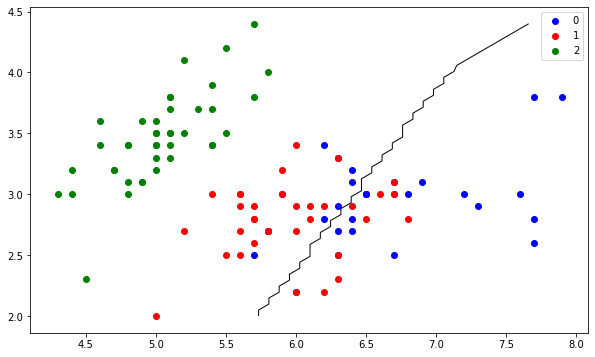

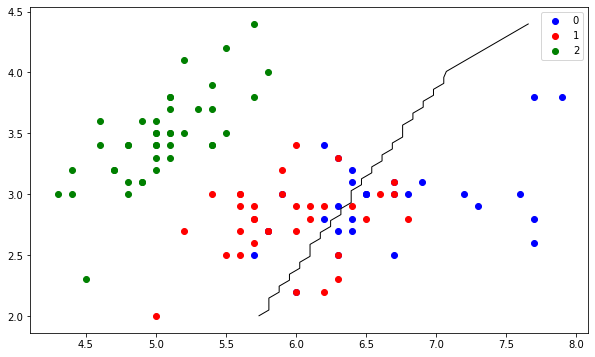

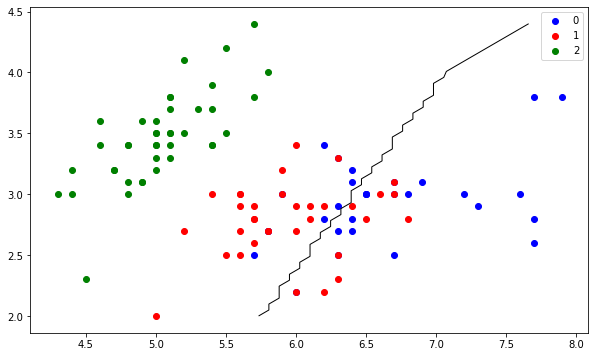

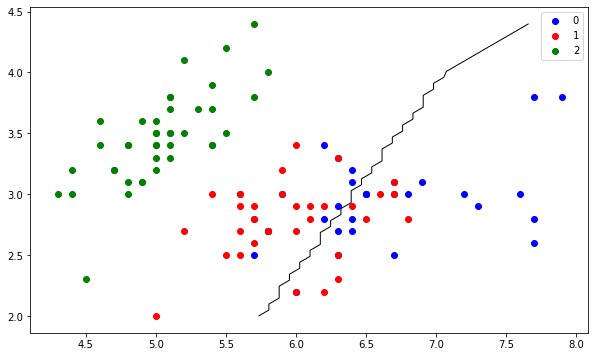

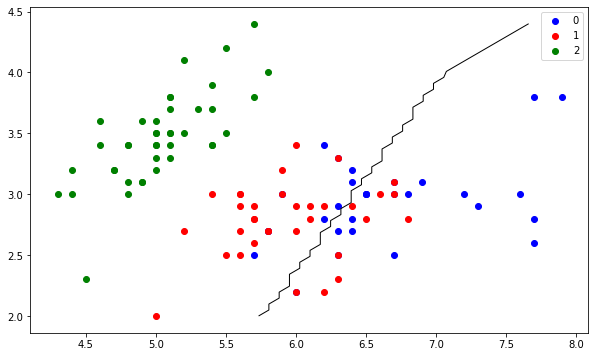

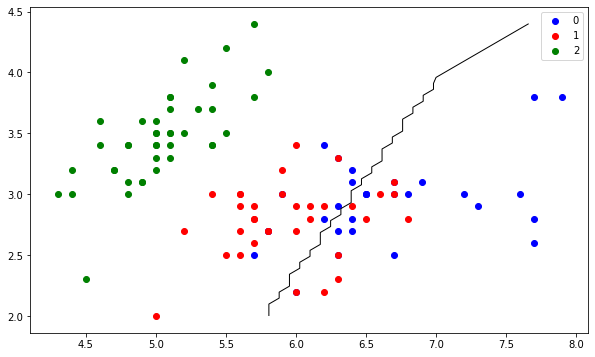

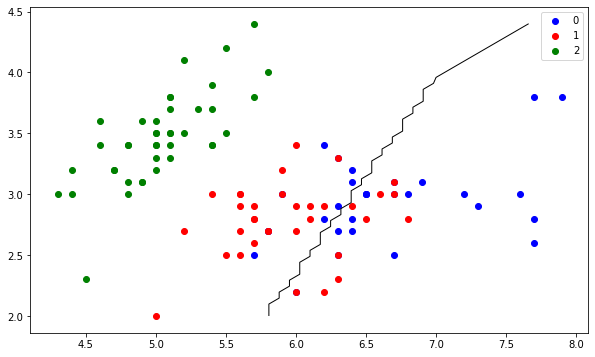

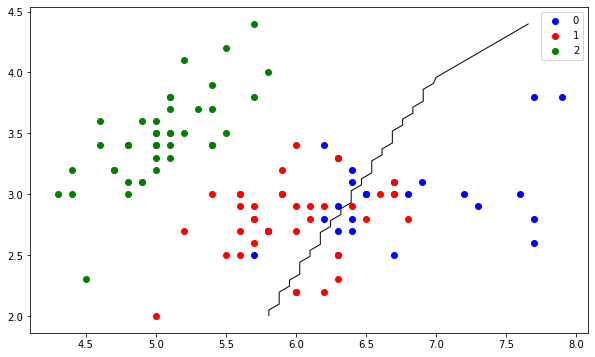

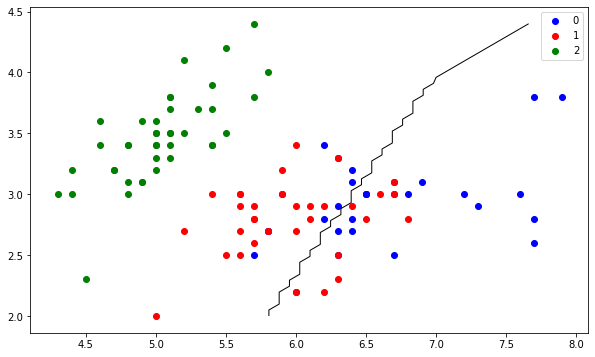

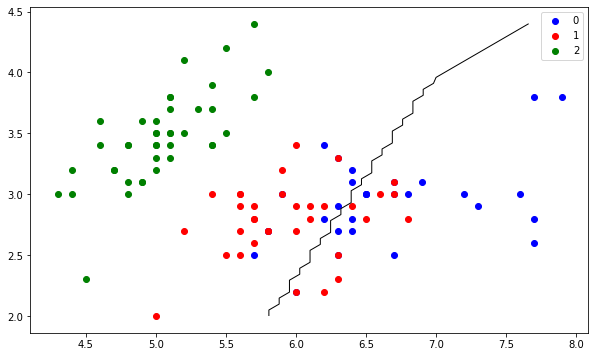

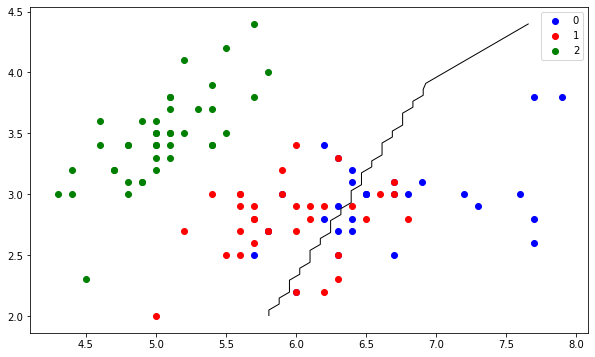

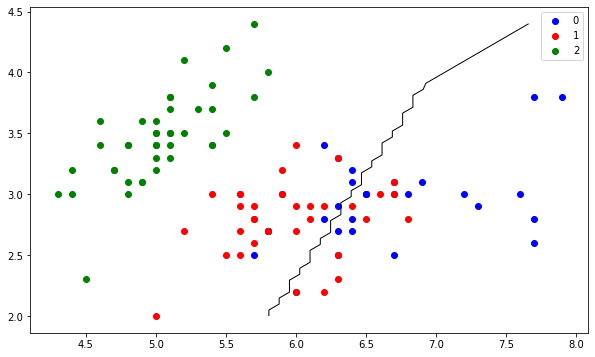

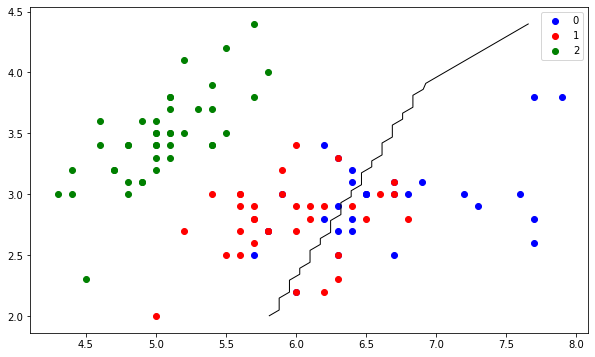

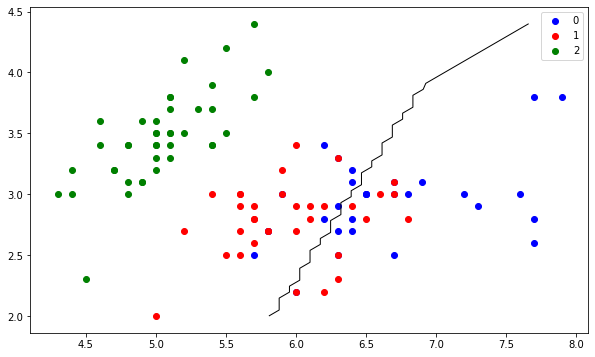

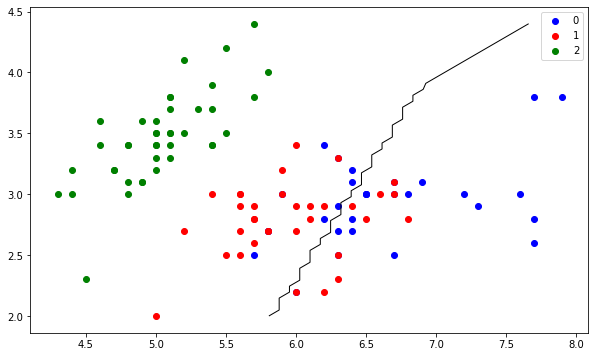

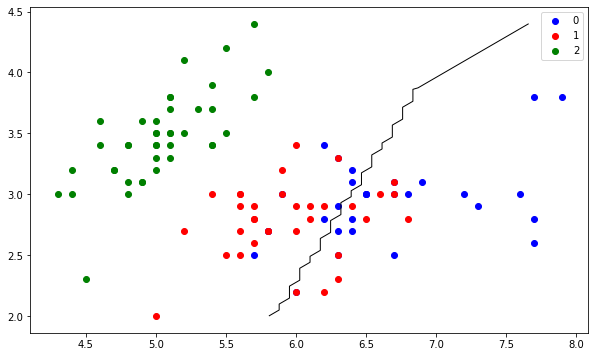

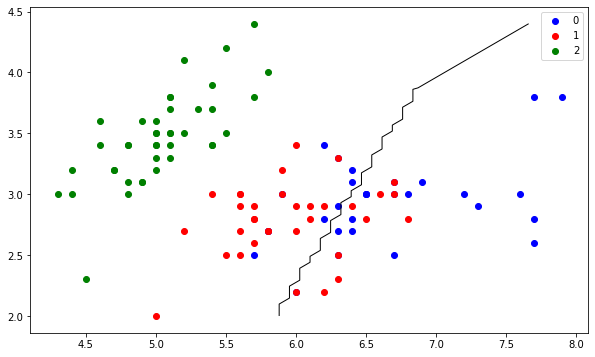

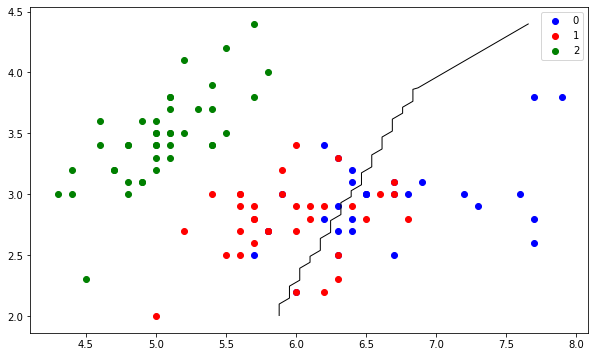

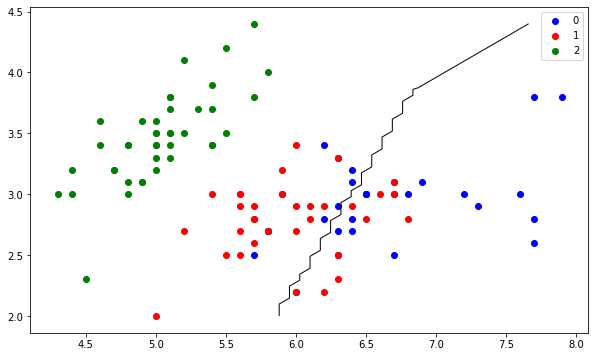

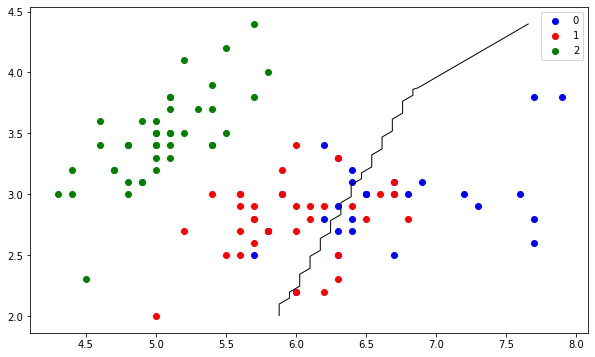

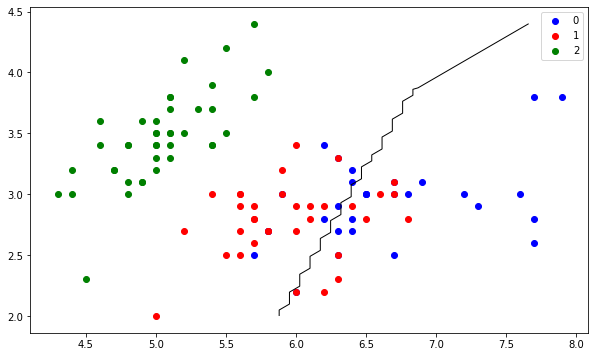

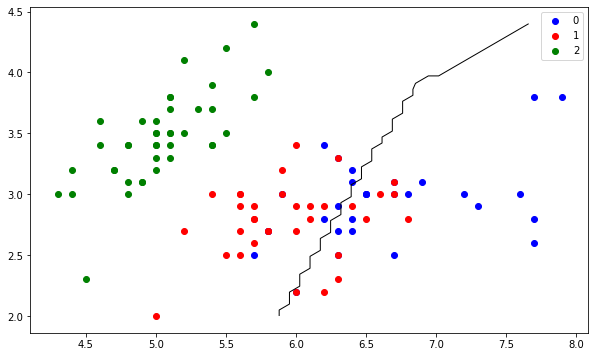

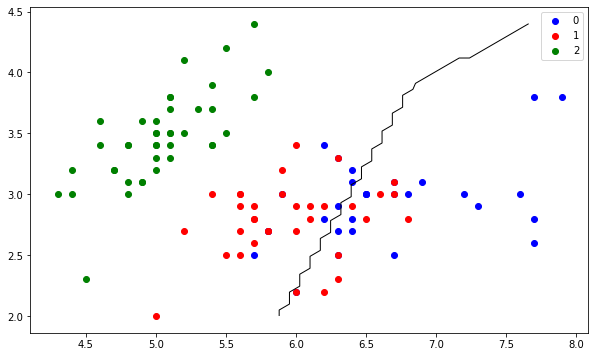

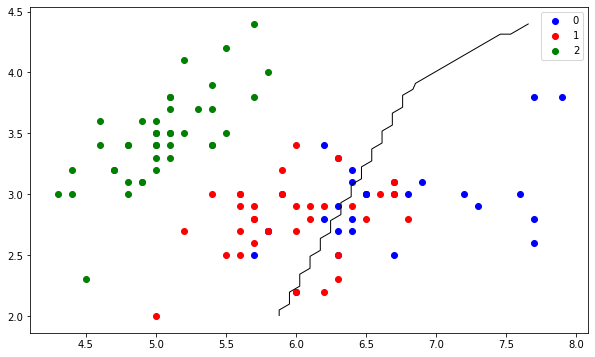

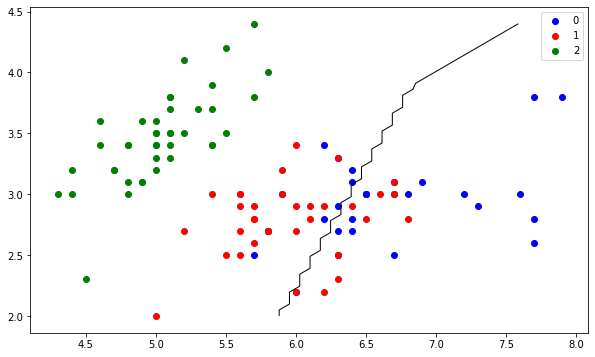

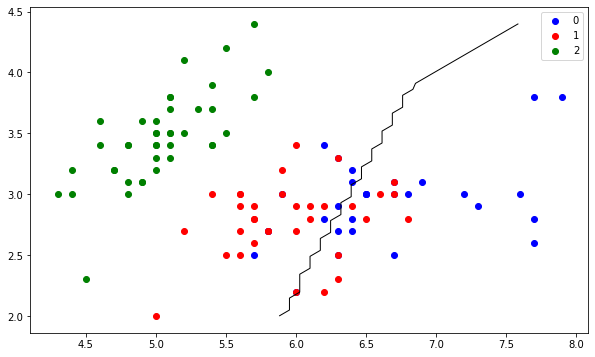

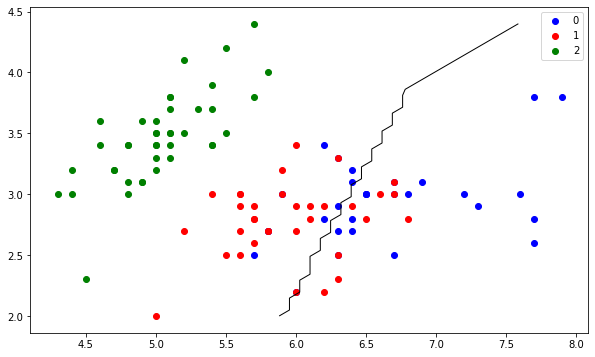

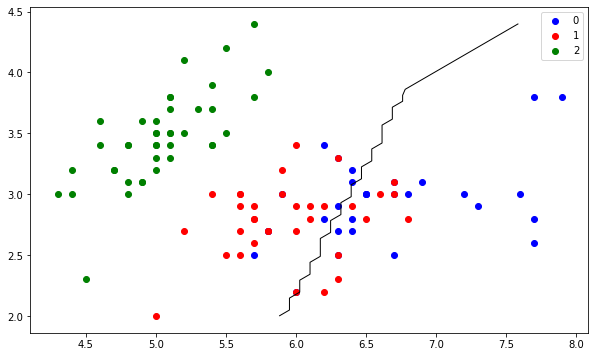

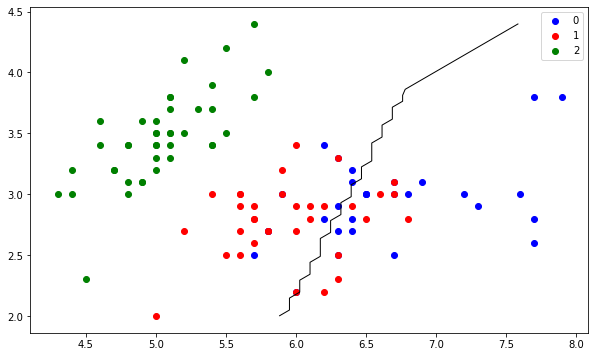

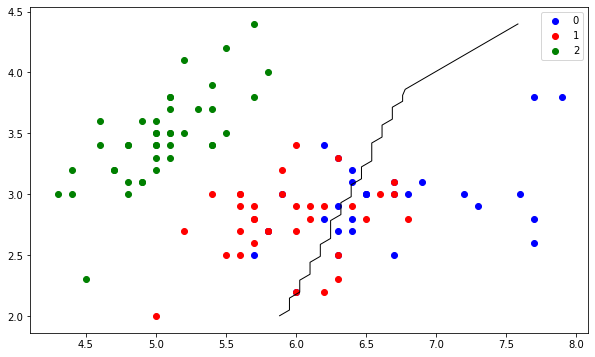

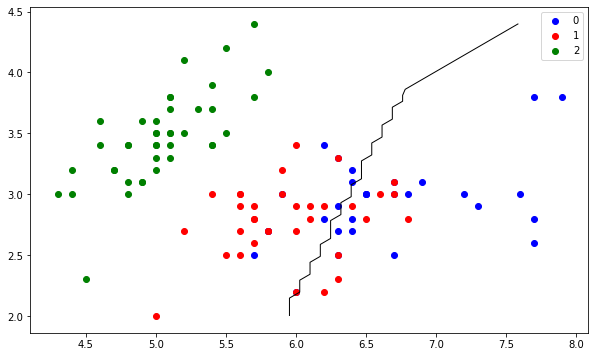

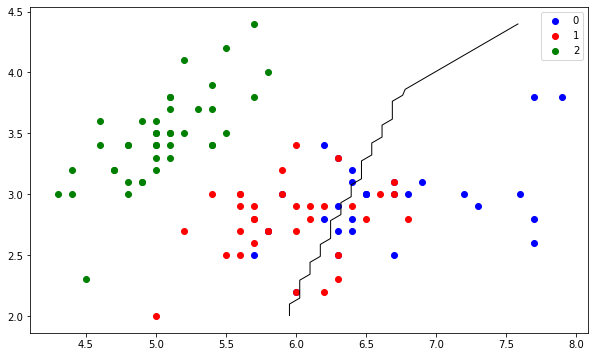

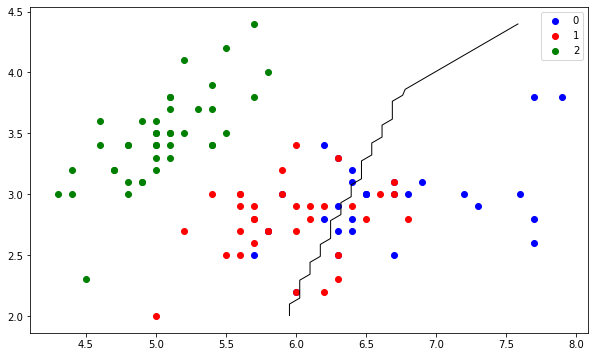

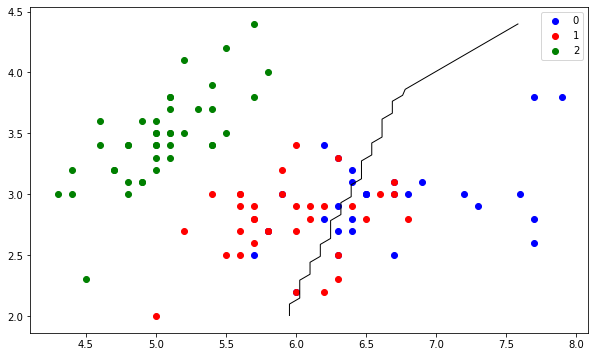

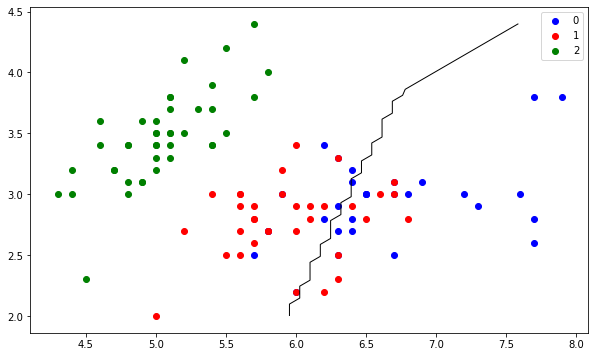

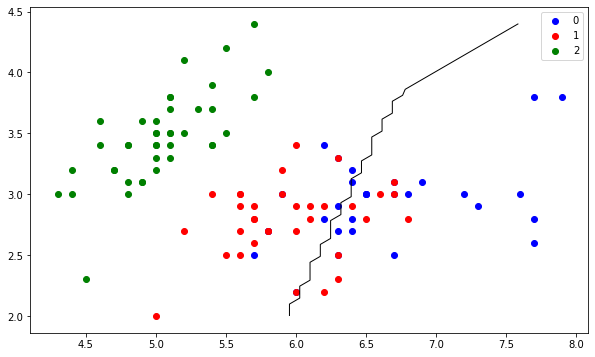

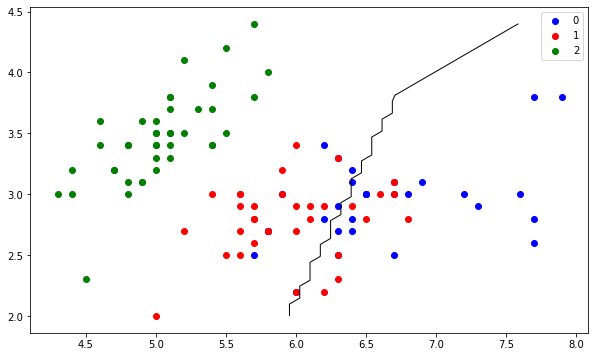

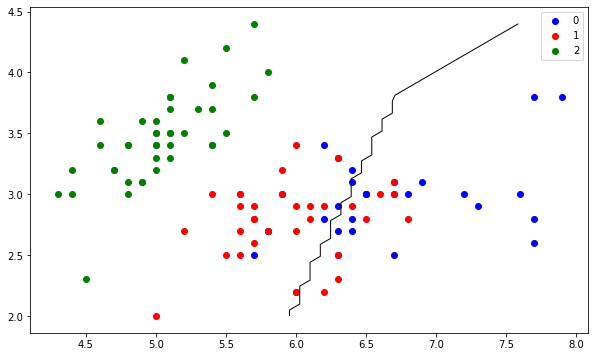

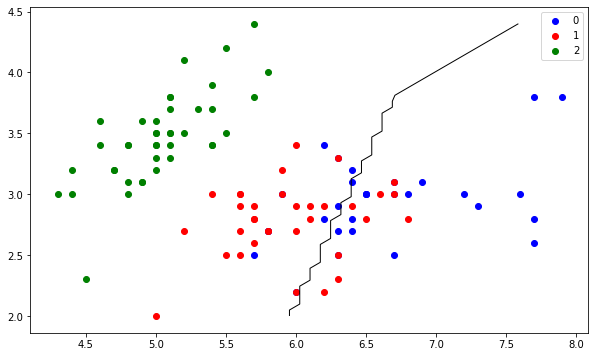

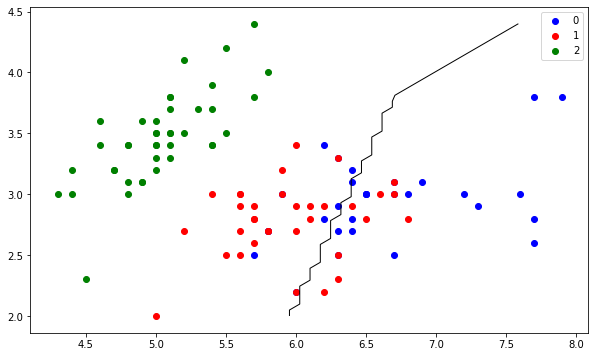

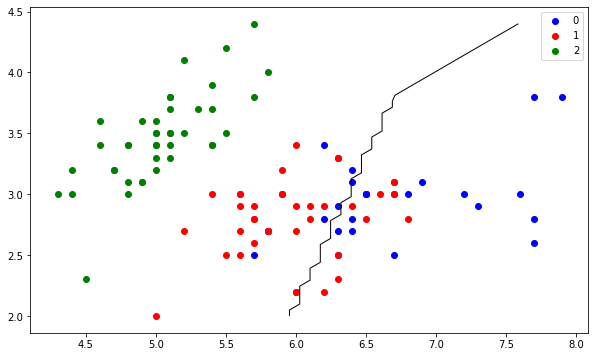

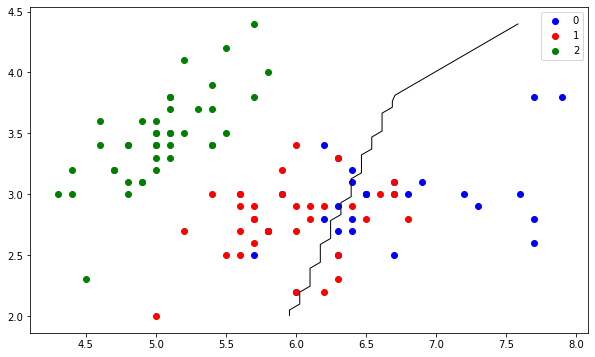

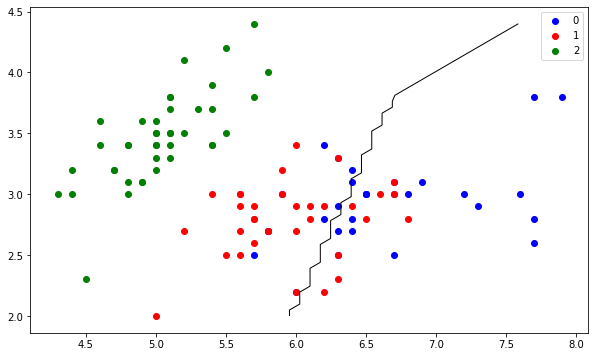

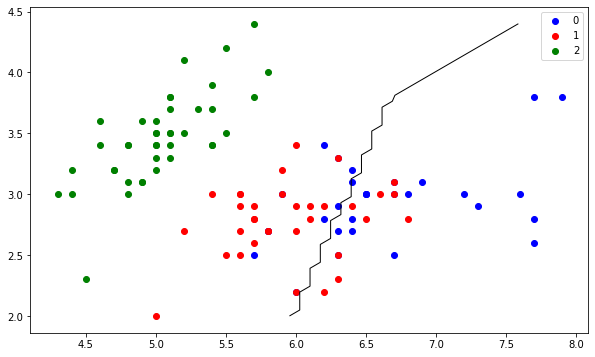

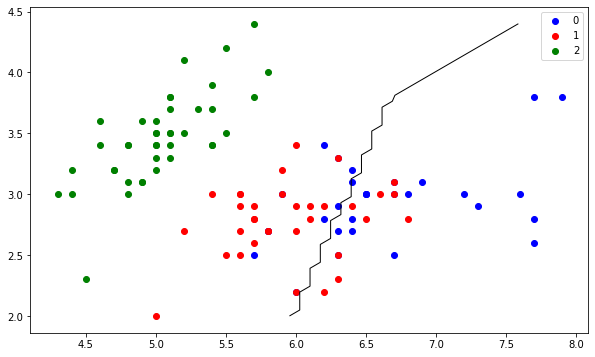

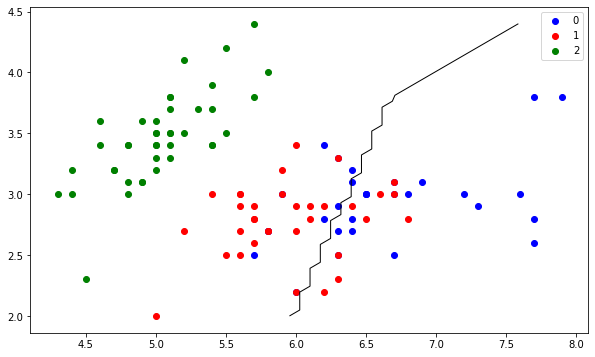

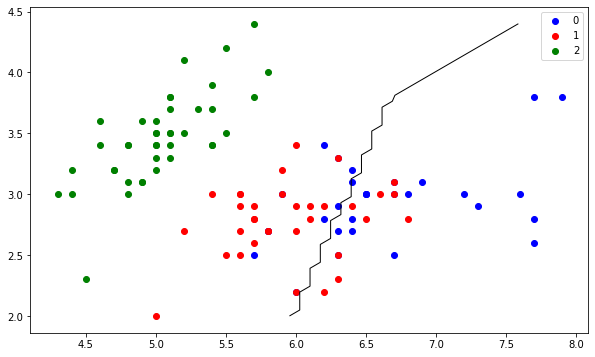

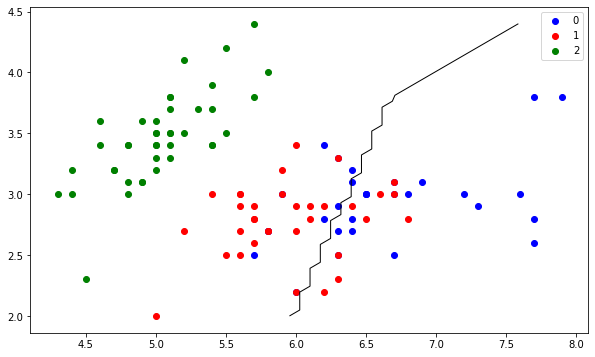

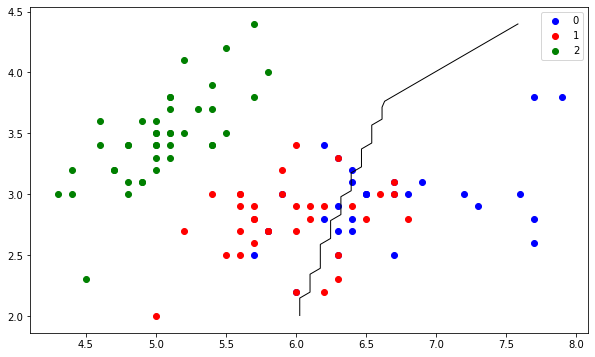

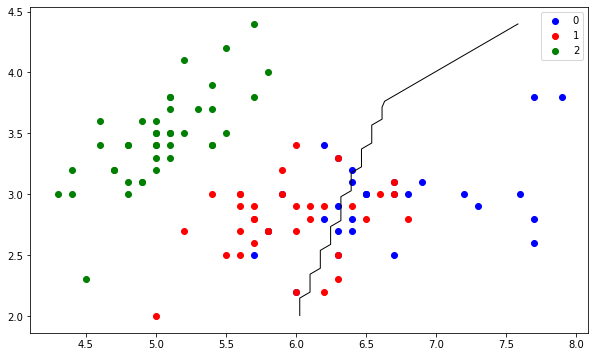

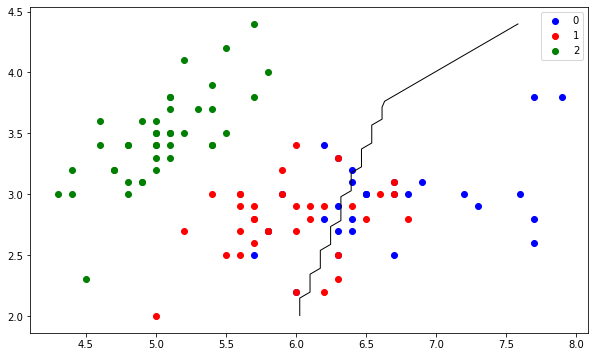

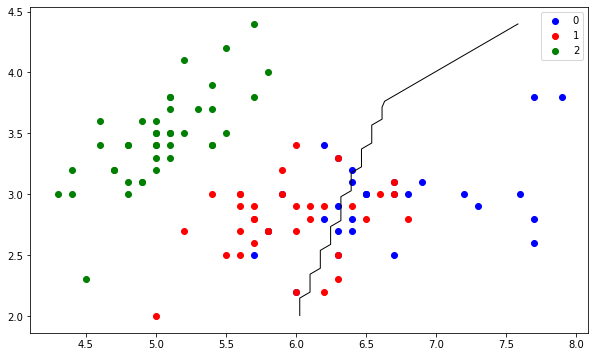

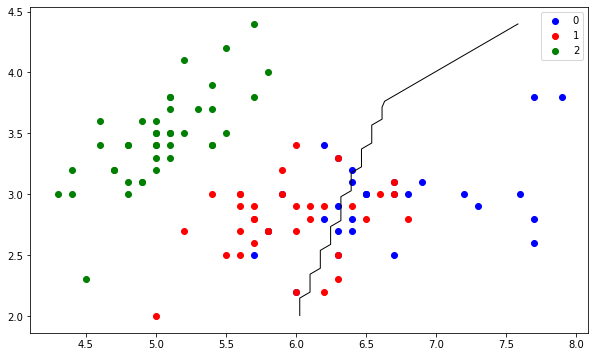

In [5]:
#Tuneable hyperparamters to c0ontrol different parts of the logistic regression training
num_epoch = 50000 #Maximum number of loops do we train for (safety check in case we never converge)
lambda_ = 0.1 #Control the importance of the regularization
learning_rate = 0.01 #How much do we update the gradients

use_l2_reg=False

for epoch in range(num_epoch):
    
    #Calculate the current hypothesis: sigmoid(Wx + b). This is also referred to as y_hat
    p = y_hat = predict_prob(X_tr, W, b)
    #Find the negative log likelihood, and add the regularization L2 loss
    loss = compute_loss(p, y_tr)
    
    if use_l2_reg:
        loss += lambda_ * l2_loss(W)
    
    
    #Use one-hot encoding
    #So label [2] -> [0, 0, 1]
    #   label [0] -> [1, 0, 0]
    y_tr_onehot = np.zeros((X_tr.shape[0], num_class))
    y_tr_onehot[np.arange(len(y_tr)), y_tr] = 1.0

    #Calculate the gradients w.r.t W and w.r.t b
    dW, db = compute_gradient(X_tr, p, y_tr_onehot)
    
    if use_l2_reg:
        dW += lambda_ * 2. * W #Add regularization to the gradient as well
    
    #Update the W,b parameters by a learning rate factor and the gradients
    W_prev = W
    W = W - learning_rate * dW
    b = b - learning_rate * db
    
    if epoch % 500 == 0:
        #Let's see how we're doing by checking the accuracy for the training data
        y_hat = predict_prob(X_tr, W, b) 
        acc_tr = np.sum(predict(y_hat) == y_tr) / len(y_tr)
        print(f'Epoch {epoch}: loss = {loss}, acc_tr = {acc_tr}')
    
        plot(X_tr, y_tr, W, b)
        
    #Break out once convergence is reached
    if np.linalg.norm(W - W_prev) < 1e-6:
        print(f"Convergence reached at epoch {epoch}: {np.linalg.norm(W - W_prev)}")
        break

In [6]:
#How did we really do?  Check against the test dataset
y_hat = predict_prob(X_te, W, b)
acc_te = np.sum(predict(y_hat) == y_te) / len(y_te)
print(f"Final Weights: {W}   bias: {b}")
print(f"Test accuracy: {acc_te}")



Final Weights: [[ 2.52715406  1.11728704 -3.64392089]
 [-3.18381597 -2.68329837  5.86630502]]   bias: [-4.73610797  2.73087382  2.00523415]
Test accuracy: 0.7555555555555555


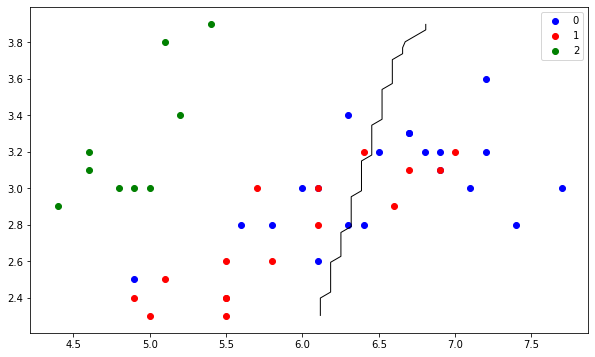

In [7]:
plot(X_te, y_te, W, b)